This code processes multiple CSV files from a specified folder, categorizing each file as either "healthy" or "unhealthy" based on its filename. It then reads each file and extracts the "Current-A" column. The extracted data is divided into chunks of 1,000 values, with each chunk forming a separate row in a table. Once all chunks are processed, a label column is added to indicate the file's category. This process is repeated for all files, and the resulting data is merged into a single table. Finally, the combined dataset is saved as a CSV file, and a confirmation message is displayed.

In [ ]:
import pandas as pd
import numpy as np
import os

# Set the folder path containing all CSV files
folder_path = 'D:\\ML\\data'

# Create an empty list to store DataFrames for each file
output_dfs = []

# Loop through all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        print(file_path)
        # Extract the file name without extension
        file_name_without_extension = file_name.split("-")[0]

        # Initialize labels_list for each file
        labels_list = []

        # Assign a label based on health condition
        label = 'healthy' if 'healthy' in file_name_without_extension.lower() else 'unhealthy'
        labels_list.append(label)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Extract the 'Current-A' column
        current_a_data = df[' Current-A']

        # Define the chunk size
        chunk_size = 1000

        # Calculate the number of complete chunks
        num_complete_chunks = len(current_a_data) // chunk_size

        # Create a list to store transposed chunks
        transposed_chunks_list = []

        # Process the data in complete chunks
        for i in range(0, num_complete_chunks * chunk_size, chunk_size):
            # Take a chunk of data
            chunk = current_a_data[i:i + chunk_size]

            # Transpose the chunk into rows
            transposed_chunk = chunk.values.reshape(1, -1)  # 1 row, 143*1000 columns

            # Append the transposed chunk to the list
            transposed_chunks_list.append(transposed_chunk)

        # Concatenate the list of transposed chunks along a new axis (axis=0)
        output_array = np.concatenate(transposed_chunks_list, axis=0)

        # Create a DataFrame from the concatenated array with a 'Label' column
        output_df = pd.DataFrame(data=output_array, columns=[f'Value_{i}' for i in range(output_array.shape[1])])
        output_df['Label'] = label

        # Append the DataFrame to the list
        output_dfs.append(output_df)

# Concatenate all DataFrames along a new axis (axis=0)
final_output_df = pd.concat(output_dfs, axis=0, ignore_index=True)

# Save the final DataFrame to a new CSV file
final_output_file_path = 'D:\\ML\\output\\final_output_with_labels.csv'
final_output_df.to_csv(final_output_file_path, index=False)

# Print a message to indicate that the final file has been saved
print(f'Final transposed data with labels saved to {final_output_file_path}')


The code loads a CSV file into a Pandas DataFrame and checks for missing values in each column using .isnull().sum().
It then prints the count of null values to identify data quality issues.
This helps in data cleaning and preprocessing before further analysis.

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = r"D:\\ML\\output\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Check for null values in the DataFrame
null_values =df.isnull().sum()
print(null_values)



Value_0      1
Value_1      1
Value_2      1
Value_3      1
Value_4      1
            ..
Value_996    2
Value_997    2
Value_998    2
Value_999    2
Label        0
Length: 1001, dtype: int64


In [3]:
df = df.dropna(axis = 0)
print(df.isnull().sum(axis = 0))

Value_0      0
Value_1      0
Value_2      0
Value_3      0
Value_4      0
            ..
Value_996    0
Value_997    0
Value_998    0
Value_999    0
Label        0
Length: 1001, dtype: int64


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Naive Bayes  for Binnary classification 

The code implements a **Naïve Bayes classifier** to distinguish between "healthy" and "unhealthy" data. It begins by loading the dataset, converting labels into binary values, and splitting the data into training and test sets. The model calculates the mean and standard deviation for each class and predicts labels using the **Gaussian probability formula**. Performance is evaluated through **accuracy, precision, recall, sensitivity, specificity, and F1-score**. Finally, the results are displayed to assess the model’s effectiveness.

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
file_path = r"D:\\ML\\output\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Convert 'Label' column to binary values
df['Label'] = df['Label'].map({'healthy': 0, 'unhealthy': 1})

# Convert dataframe to numpy array
data = df.drop('Label', axis=1).values
labels = df['Label'].values

# Define functions for Naive Bayes classifier

def separate_by_class(dataset, labels):
    separated = {}
    for label in np.unique(labels):
        separated[label] = dataset[labels == label]
    return separated

def calculate_mean_std(dataset):
    mean_std = {}
    for label, subset in dataset.items():
        mean_std[label] = {
            'mean': np.mean(subset, axis=0),
            'std': np.std(subset, axis=0)
        }
    return mean_std

def calculate_probability(x, mean, std):
    exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
    return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

def predict(summaries, input_data):
    probabilities = {}
    for label, class_summaries in summaries.items():
        probabilities[label] = 1
        for i in range(len(class_summaries['mean'])):
            mean = class_summaries['mean'][i]
            std = class_summaries['std'][i]
            x = input_data[i]
            probabilities[label] *= calculate_probability(x, mean, std)
    return max(probabilities, key=probabilities.get)

def naive_bayes(train_data, train_labels, test_data):
    separated = separate_by_class(train_data, train_labels)
    summaries = calculate_mean_std(separated)
    predictions = [predict(summaries, row) for row in test_data]
    return predictions


def accuracy_metric(actual, predicted):
    correct = sum(1 for i in range(len(actual)) if actual[i] == predicted[i])
    return correct / float(len(actual))

def precision_recall(actual, predicted):
    true_positives = sum(1 for i in range(len(actual)) if actual[i] == 1 and predicted[i] == 1)
    predicted_positives = sum(1 for i in range(len(predicted)) if predicted[i] == 1)
    actual_positives = sum(1 for i in range(len(actual)) if actual[i] == 1)

    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0

    return precision, recall

def sensitivity_specificity(actual, predicted):
    true_positives = sum(1 for i in range(len(actual)) if actual[i] == 1 and predicted[i] == 1)
    true_negatives = sum(1 for i in range(len(actual)) if actual[i] == 0 and predicted[i] == 0)
    false_positives = sum(1 for i in range(len(actual)) if actual[i] == 0 and predicted[i] == 1)
    false_negatives = sum(1 for i in range(len(actual)) if actual[i] == 1 and predicted[i] == 0)

    sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0

    return sensitivity, specificity

def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

# Split dataset into train and test sets
test_size = 0.2
split_index = int((1 - test_size) * len(data))
train_data, test_data = data[:split_index], data[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Evaluate the model
predicted = naive_bayes(train_data, train_labels, test_data)
accuracy = accuracy_metric(test_labels, predicted)
precision, recall = precision_recall(test_labels, predicted)
sensitivity, specificity = sensitivity_specificity(test_labels, predicted)
f1 = f1_score(precision, recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('F1 Score:', f1)


Accuracy: 0.8878143133462283
Precision: 0.8878143133462283
Recall: 1.0
Sensitivity: 1.0
Specificity: 0.0
F1 Score: 0.9405737704918034


# Plots for Naive Bayes

This piece of code trains and evaluates a **Naïve Bayes classifier** using **5-fold cross-validation** on a dataset labeled as "healthy" and "unhealthy." It first loads the data, encodes the labels, and splits it into training and testing sets. Then, it repeatedly trains the model on different portions of the training data and tests it on the remaining validation data. After each round, it calculates accuracy and loss for both training and validation sets. Finally, it plots graphs to show how the model's accuracy and loss change over time.

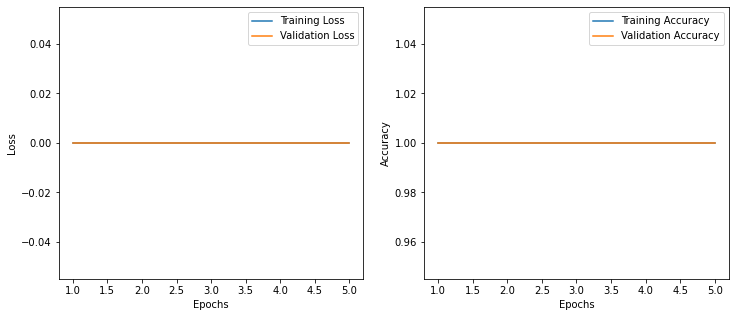

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# Define functions for plotting
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Load dataset
file_path = r"D:\\ML\\output\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Convert 'Label' column to binary values
df['Label'] = df['Label'].map({'healthy': 0, 'unhealthy': 1})

# Convert dataframe to numpy array
data = df.drop('Label', axis=1).values
labels = df['Label'].values

# Split dataset into train and test sets
test_size = 0.2
split_index = int((1 - test_size) * len(data))
train_data, test_data = data[:split_index], data[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Cross-validation to simulate the epochs
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Loop through the folds and compute the accuracies and losses
for train_index, val_index in kf.split(train_data):
    # Split data into training and validation sets
    X_train, X_val = train_data[train_index], train_data[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Train Naive Bayes and make predictions
    predictions_train = naive_bayes(X_train, y_train, X_train)  # Train predictions
    predictions_val = naive_bayes(X_train, y_train, X_val)     # Validation predictions

    # Calculate accuracy for training and validation sets
    train_accuracy = accuracy_metric(y_train, predictions_train)
    val_accuracy = accuracy_metric(y_val, predictions_val)
    
    # Calculate error (loss) as 1 - accuracy
    train_error = 1 - train_accuracy
    val_error = 1 - val_accuracy

    # Store the results
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_error)
    val_losses.append(val_error)

# Plot the curves
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies) 

# SVM for binary Classification

This piece of code starts by loading a dataset and converting the labels into binary values—0 for "healthy" and 1 for "unhealthy." It then prepares the data for machine learning by separating the features from the labels. Next, it defines a simple **Support Vector Machine (SVM)**, which learns to classify data by adjusting weights and a bias through multiple iterations. The dataset is split into training and testing sets, and the SVM is trained using the training data. Finally, the trained model makes predictions on the test data, and its accuracy is calculated to see how well it distinguishes between healthy and unhealthy cases.

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
file_path = r"D:\\ML\\output\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Convert 'Label' column to binary values
df['Label'] = df['Label'].map({'healthy': 0, 'unhealthy': 1})

# Convert dataframe to numpy array
data = df.drop('Label', axis=1).values
labels = df['Label'].values

# Define SVM class
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)  # Convert 0 labels to -1 for SVM

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights - np.dot(x_i, y_[idx]))
                    self.bias -= self.learning_rate * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

# Split dataset into train and test sets
test_size = 0.2
split_index = int((1 - test_size) * len(data))
train_data, test_data = data[:split_index], data[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Create SVM instance
svm = SVM()

# Train SVM model
svm.fit(train_data, train_labels)

# Predict using SVM model
svm_predictions = svm.predict(test_data)

# Evaluate SVM model
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

svm_accuracy = accuracy(test_labels, svm_predictions)
print('SVM Accuracy:', svm_accuracy)


SVM Accuracy: 0.8858800773694391


# Plots for SVM

The code defines an SVM class that trains a Support Vector Machine using gradient descent, updating model parameters (weights and bias) over several epochs. It computes training and validation losses and accuracies at each step, storing them for plotting. After training, the model's performance is visualized with loss and accuracy curves for both training and validation sets.

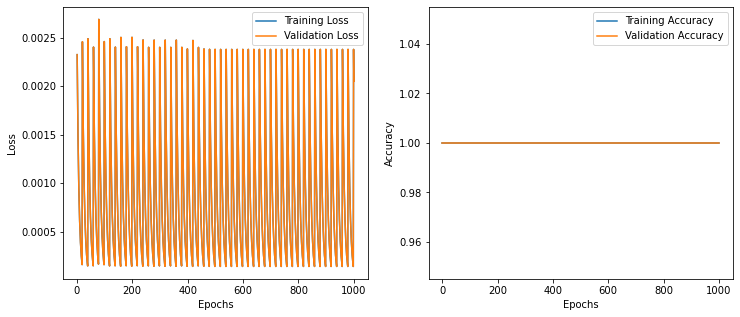

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define SVM class
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def fit(self, X_train, y_train, X_val, y_val):
        n_samples, n_features = X_train.shape
        y_train_ = np.where(y_train <= 0, -1, 1)  # Convert 0 labels to -1 for SVM
        y_val_ = np.where(y_val <= 0, -1, 1)  # Convert 0 labels to -1 for SVM

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Perform training steps
            for idx, x_i in enumerate(X_train):
                condition = y_train_[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights - np.dot(x_i, y_train_[idx]))
                    self.bias -= self.learning_rate * y_train_[idx]

            # Compute training and validation loss
            train_loss = 0.5 * np.dot(self.weights, self.weights) + self.lambda_param * np.mean(np.maximum(0, 1 - y_train_ * (np.dot(X_train, self.weights) - self.bias)))
            val_loss = 0.5 * np.dot(self.weights, self.weights) + self.lambda_param * np.mean(np.maximum(0, 1 - y_val_ * (np.dot(X_val, self.weights) - self.bias)))

            # Compute training and validation accuracy
            train_pred = np.sign(np.dot(X_train, self.weights) - self.bias)
            val_pred = np.sign(np.dot(X_val, self.weights) - self.bias)
            train_accuracy = np.mean(train_pred == y_train_)
            val_accuracy = np.mean(val_pred == y_val_)

            # Store losses and accuracies
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_accuracies.append(val_accuracy)

# Load dataset
file_path = r"D:\\ML\\output\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Convert 'Label' column to binary values
df['Label'] = df['Label'].map({'healthy': 0, 'unhealthy': 1})

# Convert dataframe to numpy array
data = df.drop('Label', axis=1).values
labels = df['Label'].values

# Split dataset into train and test sets
test_size = 0.2
split_index = int((1 - test_size) * len(data))
train_data, test_data = data[:split_index], data[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Split train set into train and validation sets
val_size = 0.1
split_index = int((1 - val_size) * len(train_data))
X_train, X_val = train_data[:split_index], train_data[split_index:]
y_train, y_val = train_labels[:split_index], train_labels[split_index:]

# Create SVM instance
svm = SVM()

# Train SVM model
svm.fit(X_train, y_train, X_val, y_val)

# Plotting
epochs = range(1, len(svm.train_losses) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, svm.train_losses, label='Training Loss')
plt.plot(epochs, svm.val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, svm.train_accuracies, label='Training Accuracy')
plt.plot(epochs, svm.val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#  MulticlassClassification

In [ ]:
import pandas as pd
import numpy as np
import os

# Set the folder path containing all CSV files
folder_path = 'D:\\ML\\data'

# Create an empty list to store DataFrames for each file
output_dfs = []

# Verify if the folder path exists
if os.path.exists(folder_path):
    # Loop through all CSV files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)
            print(file_path)

            # Read the CSV file
            df = pd.read_csv(file_path)

            # Extract the 'Current-A' column
            current_a_data = df[' Current-A']

            # Define the chunk size
            chunk_size = 1000

            # Calculate the number of complete chunks
            num_complete_chunks = len(current_a_data) // chunk_size

            # Create a list to store transposed chunks and corresponding labels
            transposed_chunks_list = []
            labels_list = []

            # Process the data in complete chunks
            for i in range(0, num_complete_chunks * chunk_size, chunk_size):
                # Take a chunk of data
                chunk = current_a_data[i:i + chunk_size]

                # Transpose the chunk into rows
                transposed_chunk = chunk.values.reshape(1, -1)  # 1 row, 143*1000 columns

                # Append the transposed chunk to the list
                transposed_chunks_list.append(transposed_chunk)

                # Assign a label with the file name
                label = file_name.split("-")[0]
                labels_list.append(label)

            # Concatenate the list of transposed chunks along a new axis (axis=0)
            output_array = np.concatenate(transposed_chunks_list, axis=0)

            # Create a DataFrame from the concatenated array with a 'Label' column
            output_df = pd.DataFrame(data=output_array, columns=[f'Value_{i}' for i in range(output_array.shape[1])])
            output_df['Label'] = labels_list

            # Append the DataFrame to the list
            output_dfs.append(output_df)

    # Concatenate all DataFrames along a new axis (axis=0)
    final_output_df = pd.concat(output_dfs, axis=0, ignore_index=True)

    # Set the final output file path
    final_output_file_path = r'D:\\ML\\output_for_multiclass\\final_output_with_labels.csv'

    # Save the final DataFrame to the specified CSV file path
    final_output_df.to_csv(final_output_file_path, index=False)

    # Print a message to indicate that the final file has been saved
    print(f'Final transposed data with labels saved to {final_output_file_path}')
else:
    print(f"The folder path '{folder_path}' does not exist.")


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = r"D:\\ML\\output_for_multiclass\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Now you can perform operations on the DataFrame 'df'


# Check for null values in the DataFrame
null_values =df.isnull().sum()

# Display or print the null values
print("Null Values:\n", null_values)



Null Values:
 Value_0      1
Value_1      1
Value_2      1
Value_3      1
Value_4      1
            ..
Value_996    2
Value_997    2
Value_998    2
Value_999    2
Label        0
Length: 1001, dtype: int64


In [13]:
df = df.dropna(axis = 0)
print(df.isnull().sum(axis = 0))


Value_0      0
Value_1      0
Value_2      0
Value_3      0
Value_4      0
            ..
Value_996    0
Value_997    0
Value_998    0
Value_999    0
Label        0
Length: 1001, dtype: int64


# Naive Bayes  for Multiclass

here i build a Naive Bayes classifier to predict multiple classes from a dataset. It first loads the data, splits it by class, and calculates the mean and standard deviation for each feature in every class. For predictions, it calculates the likelihood of each class and picks the one with the highest probability. The model then tests its predictions on a separate test set and checks how often it gets them right, calculating the accuracy. Finally, the accuracy is printed to see how well the model performed.

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
file_path = r"D:\\ML\\output_for_multiclass\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Convert dataframe to numpy array
data = df.drop('Label', axis=1).values
labels = df['Label'].values

# Define functions for Naive Bayes classifier

def separate_by_class(dataset, labels):
    separated = {}
    for label in np.unique(labels):
        separated[label] = dataset[labels == label]
    return separated

def calculate_mean_std(dataset):
    mean_std = {}
    for label, subset in dataset.items():
        mean_std[label] = {
            'mean': np.mean(subset, axis=0),
            'std': np.std(subset, axis=0)
        }
    return mean_std

def calculate_probability(x, mean, std):
    exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
    return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

def predict(summaries, input_data):
    probabilities = {}
    for label, class_summaries in summaries.items():
        probabilities[label] = 1
        for i in range(len(class_summaries['mean'])):
            mean = class_summaries['mean'][i]
            std = class_summaries['std'][i]
            x = input_data[i]
            probabilities[label] *= calculate_probability(x, mean, std)
    return max(probabilities, key=probabilities.get)

def naive_bayes(train_data, train_labels, test_data):
    separated = separate_by_class(train_data, train_labels)
    summaries = calculate_mean_std(separated)
    predictions = [predict(summaries, row) for row in test_data]
    return predictions

def accuracy_metric(actual, predicted):
    correct = sum(1 for i in range(len(actual)) if actual[i] == predicted[i])
    return correct / float(len(actual))

# Split dataset into train and test sets
test_size = 0.2
split_index = int((1 - test_size) * len(data))
train_data, test_data = data[:split_index], data[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Evaluate the model
predicted = naive_bayes(train_data, train_labels, test_data)
accuracy = accuracy_metric(test_labels, predicted)

print('Accuracy:', accuracy)

Accuracy: 0.059961315280464215


# Plot for Naive Bayes Multiclass

In this code,first splitting the dataset into training and validation sets using train_test_split from scikit-learn. Then, train the Naive Bayes classifier on the training data and use it to predict both training and validation data. The accuracy is calculated for both the training and validation sets by comparing the predicted results with the actual labels. Finally,I plot the training and validation accuracy across multiple epochs (in this case, just using the same accuracy value for 10 epochs) to visualize how the model performs during training. The plot helps compare the accuracy on both datasets.

Training Accuracy: 0.10469052224371374
Validation Accuracy: 0.08220502901353965


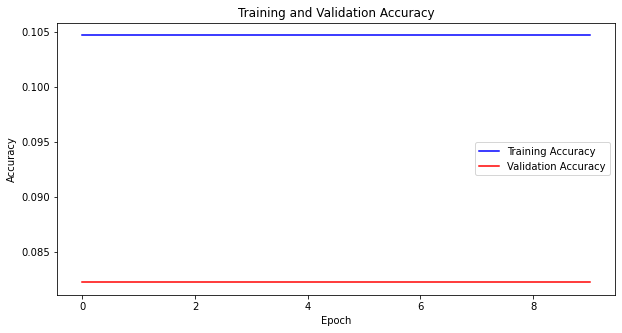

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split dataset into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier
predicted_train = naive_bayes(train_data, train_labels, train_data)
predicted_val = naive_bayes(train_data, train_labels, val_data)

# Calculate accuracy for training and validation data
train_accuracy = accuracy_metric(train_labels, predicted_train)
val_accuracy = accuracy_metric(val_labels, predicted_val)

print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot([train_accuracy] * 10, label='Training Accuracy', color='blue')
plt.plot([val_accuracy] * 10, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()  

# SVM for Multiclass Classification

In this code, I implemented a multiclass classification model using a **One-vs-Rest (OvR)** approach with Support Vector Machines (SVMs). The dataset is loaded, and the labels are converted into numeric values to handle multiple classes. The MulticlassSVM class is designed to train a separate binary SVM classifier for each class, transforming the multiclass labels into binary labels for each individual classifier. The binary SVM model is then trained using stochastic gradient descent to learn the optimal weights and bias. After splitting the data into training and testing sets, the model makes predictions on the test set, and the accuracy of the multiclass SVM is calculated and printed. This approach allows the model to classify data into multiple classes by leveraging multiple binary classifiers and selecting the class with the highest probability during prediction.

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
file_path = r"D:\\ML\\output_for_multiclass\\final_output_with_labels.csv"
df = pd.read_csv(file_path)

# Define labels and convert them to binary values
labels = df['Label'].unique()
label_map = {label: idx for idx, label in enumerate(labels)}
df['Label'] = df['Label'].map(label_map)

# Convert dataframe to numpy array
data = df.drop('Label', axis=1).values
labels = df['Label'].values

# Define SVM class for multiclass classification
class MulticlassSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.classifiers = []

    def fit(self, X, y):
        self.classifiers = []
        for class_label in np.unique(y):
            svm = SVM()
            y_binary = np.where(y == class_label, 1, -1)
            svm.fit(X, y_binary)
            self.classifiers.append(svm)

    def predict(self, X):
        predictions = []
        for classifier in self.classifiers:
            predictions.append(classifier.predict(X))
        return np.argmax(predictions, axis=0)

# Define SVM class for binary classification
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights - np.dot(x_i, y[idx]))
                    self.bias -= self.learning_rate * y[idx]

    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

# Split dataset into train and test sets
test_size = 0.2
split_index = int((1 - test_size) * len(data))
train_data, test_data = data[:split_index], data[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Create MulticlassSVM instance
multiclass_svm = MulticlassSVM()

# Train MulticlassSVM model
multiclass_svm.fit(train_data, train_labels)

# Predict using MulticlassSVM model
svm_predictions = multiclass_svm.predict(test_data)

# Evaluate MulticlassSVM model
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

svm_accuracy = accuracy(test_labels, svm_predictions)
print('Multiclass SVM Accuracy:', svm_accuracy)



Multiclass SVM Accuracy: 0.23500967117988394


# SVM Multiclass training and validation plot

In this code, a multiclass **Support Vector Machine (SVM) model** is built using a One-vs-Rest strategy. The **MulticlassSVM** class trains a binary SVM for each unique class in the dataset by converting the multiclass labels into binary values for each classifier. It uses **stochastic gradient descent** to fit the models and calculates accuracy and hinge loss for both training and validation sets. The training process is followed by predicting the labels for the training and validation data, and then the accuracy and loss for both datasets are computed and printed. Additionally, the results are visualized through plots that show the accuracy and loss curves for each epoch (simulated here as 10 epochs).

Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Epoch 10: Train Loss = nan, Validation Loss = nan
Training Accuracy (SVM): 0.07108317214700194
Validation Accuracy (SVM): 0.08413926499032882
Training Loss (SVM): 1.0
Validation Loss (SVM): 1.0


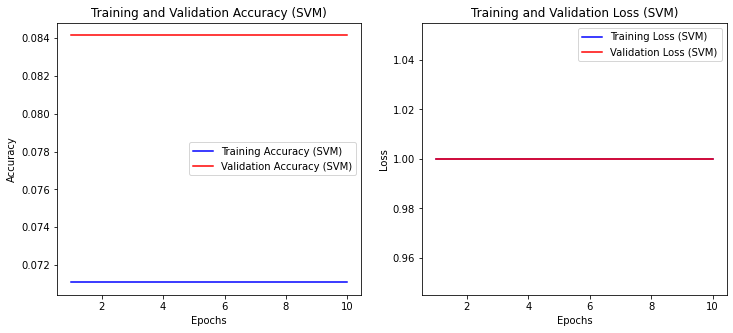

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
class MulticlassSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=10):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.classifiers = []

    def fit(self, X_train, y_train, X_val, y_val):
        self.unique_classes = np.unique(y_train)
        self.classifiers = []

        for class_label in self.unique_classes:
            svm = SVM(self.learning_rate, self.lambda_param, self.n_iterations)
            y_binary = np.where(y_train == class_label, 1, -1)  
            y_val_binary = np.where(y_val == class_label, 1, -1)  

            svm.fit(X_train, y_binary, X_val, y_val_binary)  # Now passing validation data
            self.classifiers.append(svm)

    def predict(self, X):
        predictions = np.array([svm.predict(X) for svm in self.classifiers])  
        return self.unique_classes[np.argmax(predictions, axis=0)]


# Function to calculate hinge loss
def hinge_loss(y_true, y_pred):
    return np.mean(np.maximum(0, 1 - y_true * y_pred))

# Split dataset into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create MulticlassSVM instance
multiclass_svm = MulticlassSVM()

# Train MulticlassSVM model
multiclass_svm.fit(train_data, train_labels, val_data, val_labels)  
# Predict using MulticlassSVM model
svm_predictions_train = multiclass_svm.predict(train_data)
svm_predictions_val = multiclass_svm.predict(val_data)

# Calculate accuracy for training and validation data
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

train_accuracy_svm = accuracy(train_labels, svm_predictions_train)
val_accuracy_svm = accuracy(val_labels, svm_predictions_val)

# Calculate hinge loss for training and validation data
train_loss_svm = hinge_loss(train_labels, svm_predictions_train)
val_loss_svm = hinge_loss(val_labels, svm_predictions_val)

print('Training Accuracy (SVM):', train_accuracy_svm)
print('Validation Accuracy (SVM):', val_accuracy_svm)
print('Training Loss (SVM):', train_loss_svm)
print('Validation Loss (SVM):', val_loss_svm)

# Plotting accuracy and loss
epochs = range(1, 11)  # Simulating 10 epochs for visualization

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, [train_accuracy_svm] * 10, label='Training Accuracy (SVM)', color='blue')
plt.plot(epochs, [val_accuracy_svm] * 10, label='Validation Accuracy (SVM)', color='red')
plt.title('Training and Validation Accuracy (SVM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, [train_loss_svm] * 10, label='Training Loss (SVM)', color='blue')
plt.plot(epochs, [val_loss_svm] * 10, label='Validation Loss (SVM)', color='red')
plt.title('Training and Validation Loss (SVM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
